# Results of parametric tests

In [1]:
import numpy  as np
import pandas as pd
import time
import os
%matplotlib notebook
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, tile, maximum, minimum
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm

**Reader**

In [2]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

In [4]:
instance = files[1]
full_path = path + instance

In [5]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'PD_Improved'

In [6]:
df_collected = pd.read_excel(out_folder+'Critical.xlsx', index_col=0)
df_collected.describe()

,τ,σ,ρ,its,dist_obj,time
count,36000.000000,36000.000000,36000.000000,36000.000000,3.600000e+04,36000.000000
mean,20.409013,20.409013,1.000000,1995.273722,5.038008e-01,0.107862
std,26.122256,26.122256,0.707117,59.047003,4.820606e-01,0.003419
min,0.000074,0.000074,0.001370,124.000000,8.428000e-11,0.006884
25%,0.006797,0.006797,0.292893,1999.000000,1.408371e-05,0.107180
50%,1.066272,1.066272,1.000000,1999.000000,5.980131e-01,0.108190
75%,40.400000,40.400000,1.707107,1999.000000,1.000000e+00,0.108615
max,80.000000,80.000000,1.998630,1999.000000,1.000000e+00,0.185857


## ```8x8```

Observing the relative objective distance to the true objective, we find that many tests reached a distance smaller than the threshold of ```1e-7```:

<IPython.core.display.Javascript object>


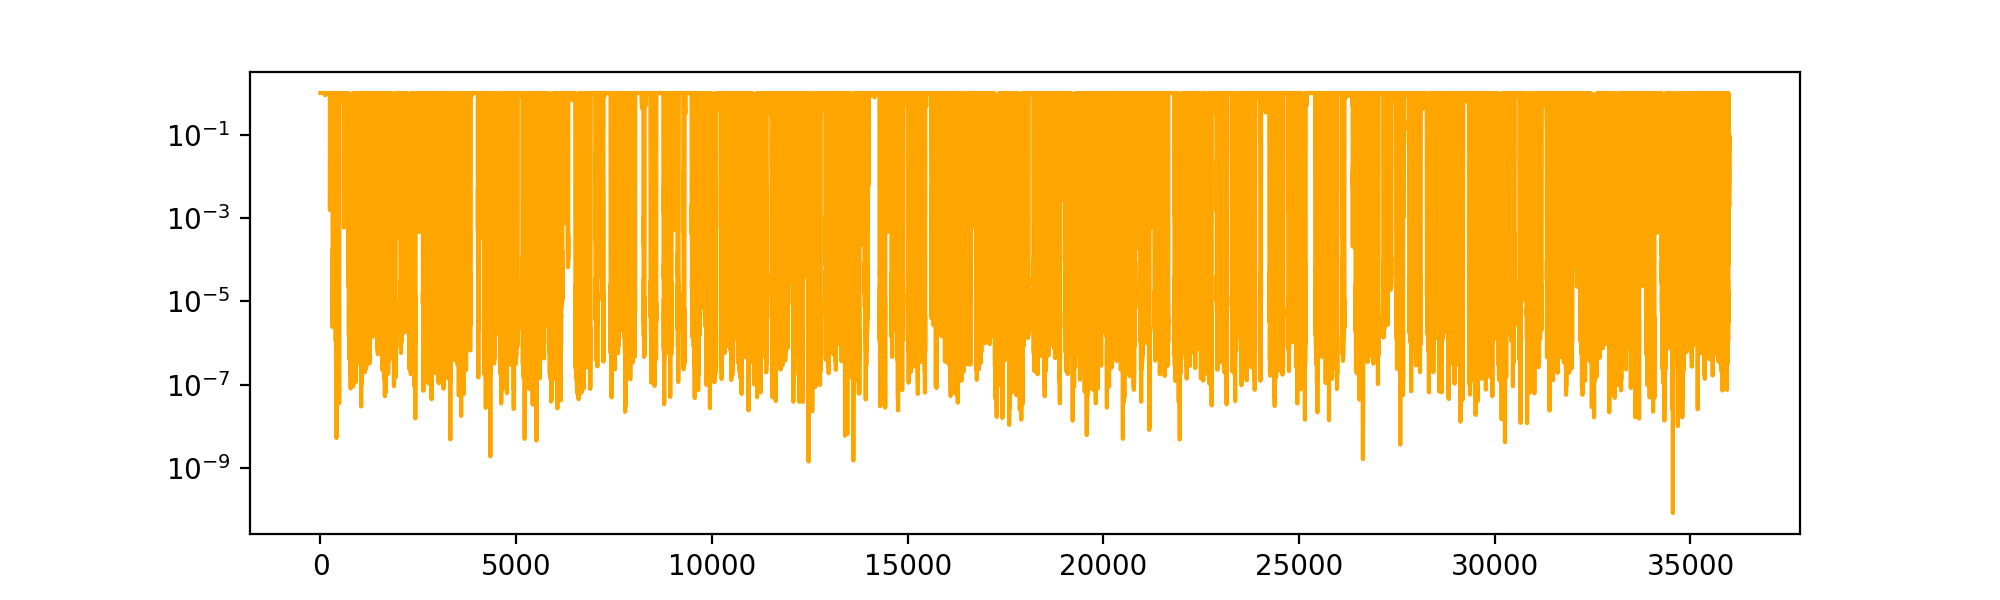

In [19]:
plt.figure(figsize = (10,3));    df_collected['dist_obj'].plot(c='orange');    plt.yscale('log');    plt.show()

If we run 
```Python
    int(df_collected[df_collected['dist_obj'] <= 1e-7].describe()['its'].max())
```
we can find that the tests reaching values below the prescribed threshold are actually the tests that finished before the iteration limit.

<IPython.core.display.Javascript object>


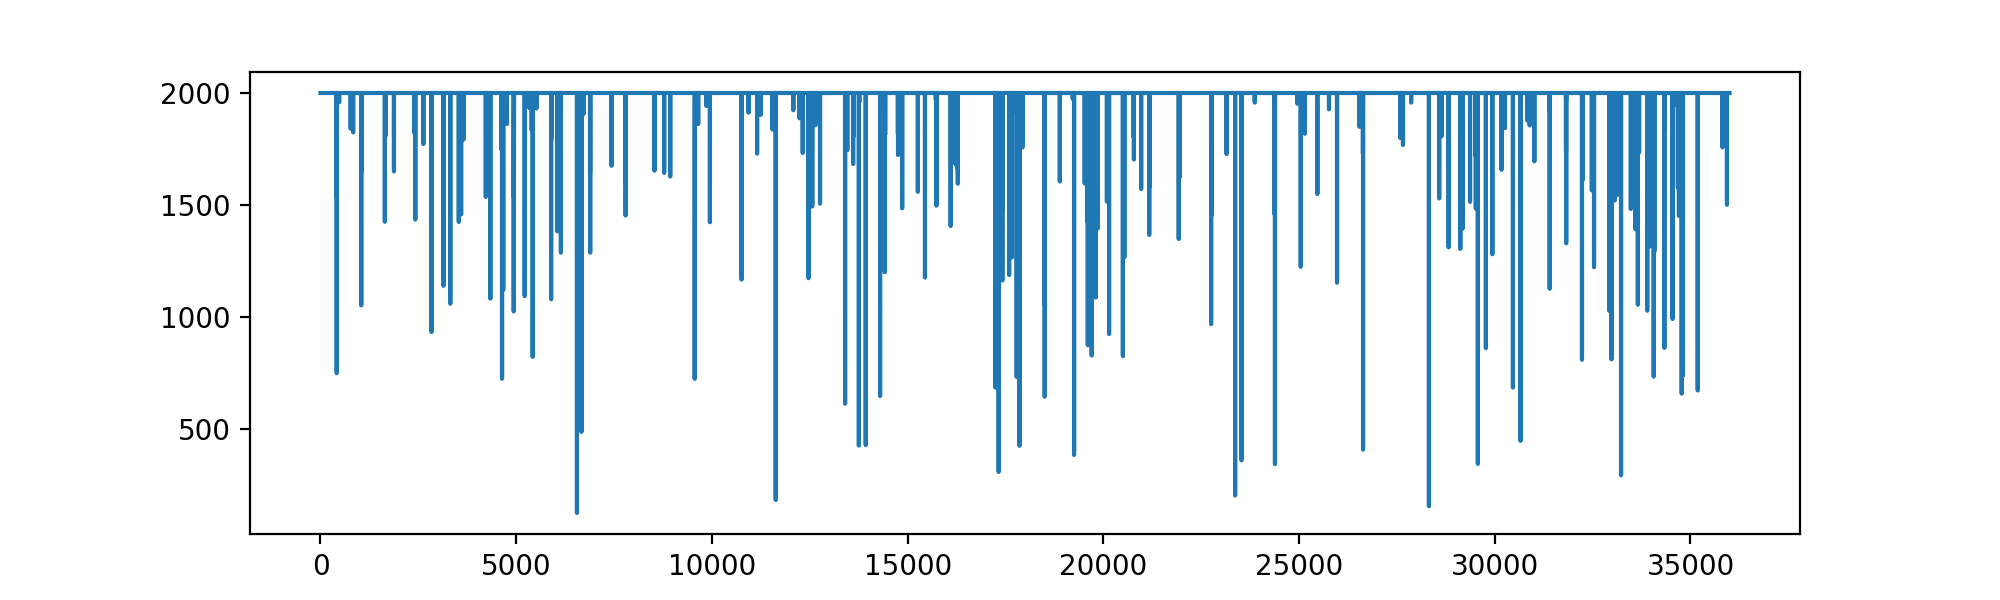

In [18]:
plt.figure(figsize = (10,3));    df_collected['its'].plot();    plt.show()

This allows us to reduce the number of observations substantially.

In [9]:
df_1999 = df_collected[df_collected['its'] < 1999]
df_1999.describe()

,τ,σ,ρ,its,dist_obj,time
count,245.000000,245.000000,245.000000,245.000000,2.450000e+02,245.000000
mean,0.009765,57.724082,1.590525,1451.465306,5.158877e-08,0.078912
std,0.008457,17.602839,0.419434,464.133853,2.851431e-08,0.025175
min,0.000493,3.200000,0.012312,124.000000,8.428000e-11,0.006884
25%,0.005036,48.000000,1.358368,1186.000000,2.793833e-08,0.064683
50%,0.008810,62.400000,1.707107,1576.000000,5.034781e-08,0.085631
75%,0.011834,72.000000,1.933580,1821.000000,7.592934e-08,0.098925
max,0.074581,80.000000,1.998630,1982.000000,9.978197e-08,0.107818


Running
```
    int(df_1999.drop_duplicates(subset=['τ','σ']).describe().iloc[0,0])
```
We can further observe that there are 78 pairs of values $(\tau,\sigma) \in \Theta_2$ for which more than one value of $\rho$ resulted in a _successful_ test.

In [10]:
df_1999[df_1999.duplicated(subset=['τ','σ'])]

,τ,σ,ρ,its,dist_obj,time
412,0.008218,72.0,1.707107,1541,6.947582e-08,0.083620
415,0.008218,72.0,1.891007,748,3.269670e-08,0.040653
1042,0.004214,68.8,1.707107,1051,9.941012e-08,0.057003
2847,0.002010,73.6,1.965926,1886,7.303942e-08,0.102083
4938,0.008405,70.4,1.358368,1044,2.616010e-08,0.056818
...,...,...,...,...,...,...
34552,0.011207,52.8,1.707107,1898,8.428000e-11,0.102898
34679,0.005547,38.4,1.998630,1576,1.021302e-08,0.085611
34706,0.013314,64.0,1.933580,1450,8.707181e-08,0.078956
34708,0.013314,64.0,1.987688,1785,8.132647e-08,0.096949


<IPython.core.display.Javascript object>


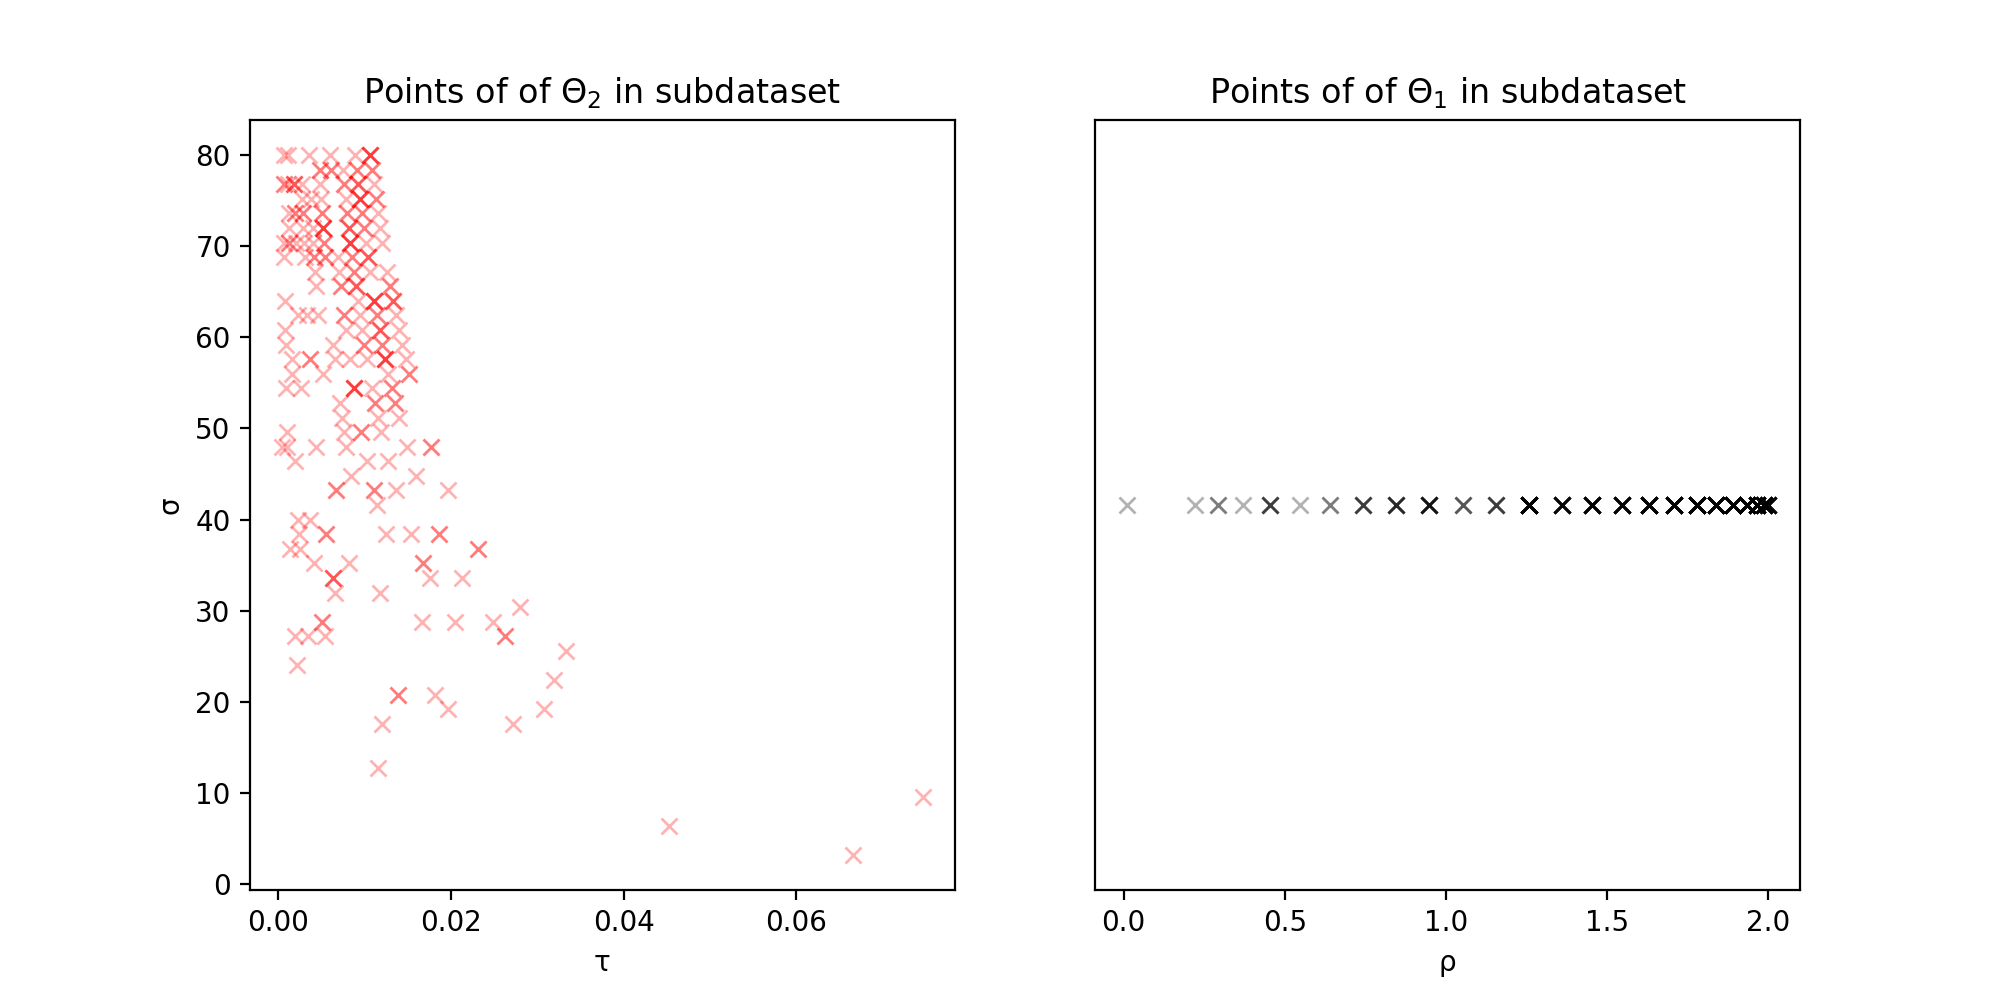

In [17]:
# Visualise grids
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.title(r'Points of of $\Theta_2$ in subdataset')
plt.plot(df_1999['τ'],df_1999['σ'],'x',color='red',alpha=0.3)
plt.xlabel('τ');    plt.ylabel('σ');

plt.subplot(1, 2, 2)
plt.title(r'Points of of $\Theta_1$ in subdataset')
plt.plot(df_1999['ρ'], 0*df_1999['ρ'],'x', color='black', alpha=0.3)
plt.xlabel('ρ');
plt.yticks([], [])

plt.show()

<IPython.core.display.Javascript object>


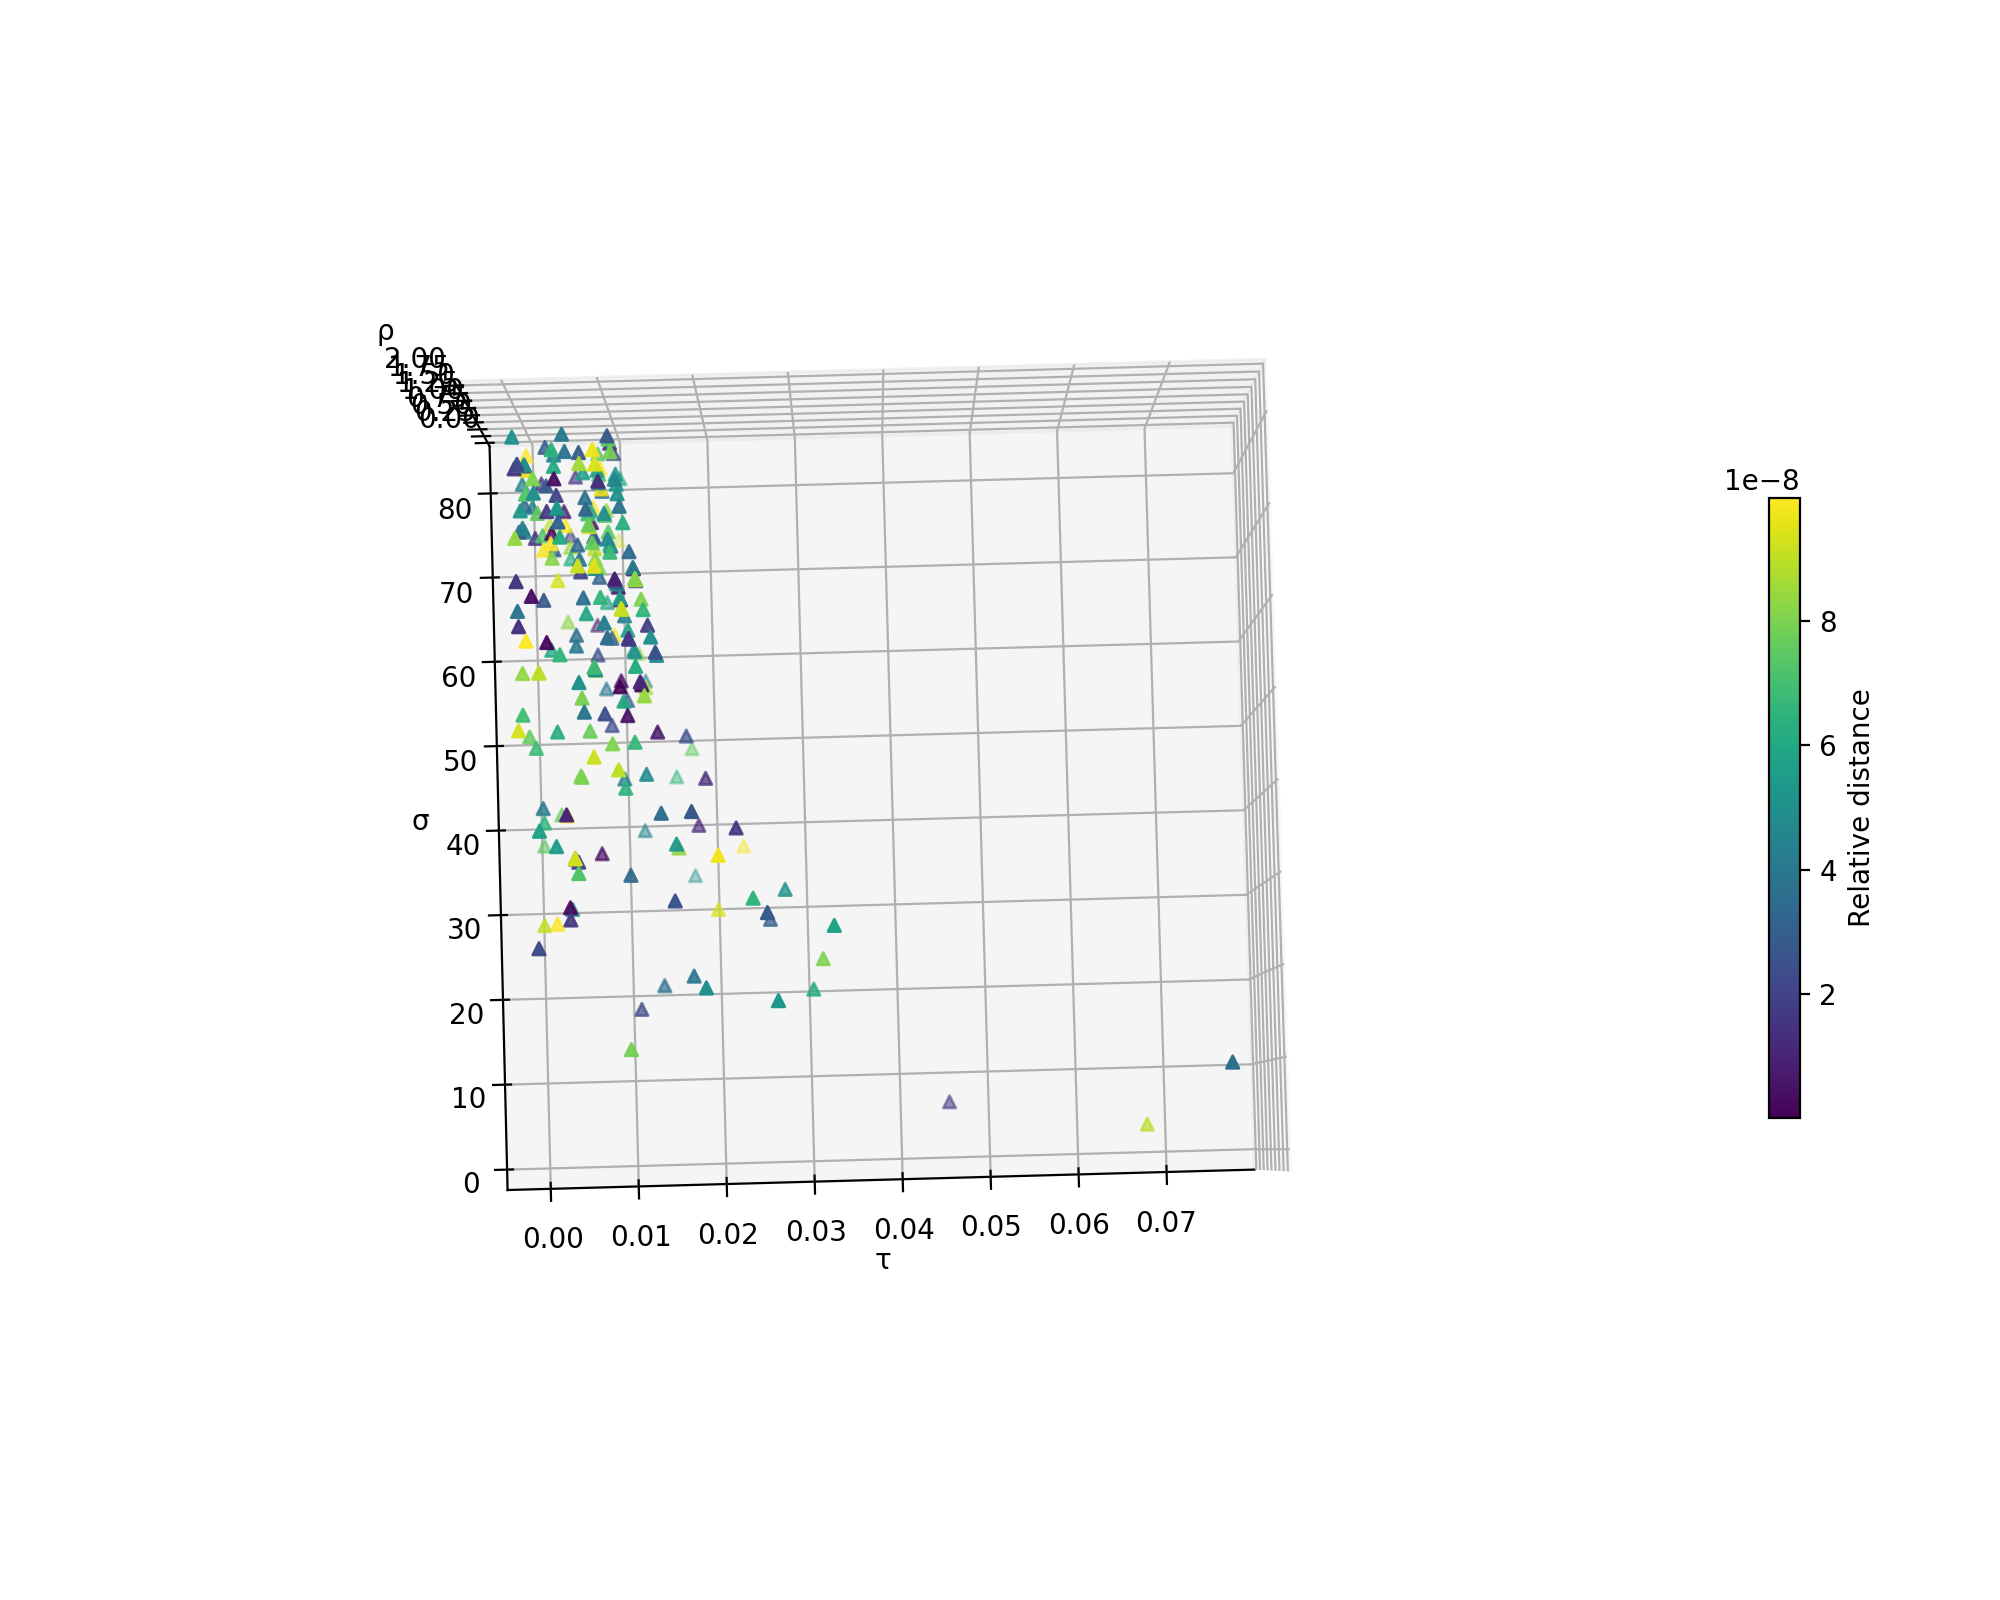

In [93]:
# Plot each parameter and resulting distance (coloured)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(df_1999['τ'], df_1999['σ'], df_1999['ρ'], marker='^', c=df_1999['dist_obj'])

ax.set_xlabel('τ')
ax.set_ylabel('σ')
ax.set_zlabel('ρ')
plt.colorbar(sc,fraction=0.02, pad=0.2,label='Relative distance')

plt.show()

<IPython.core.display.Javascript object>


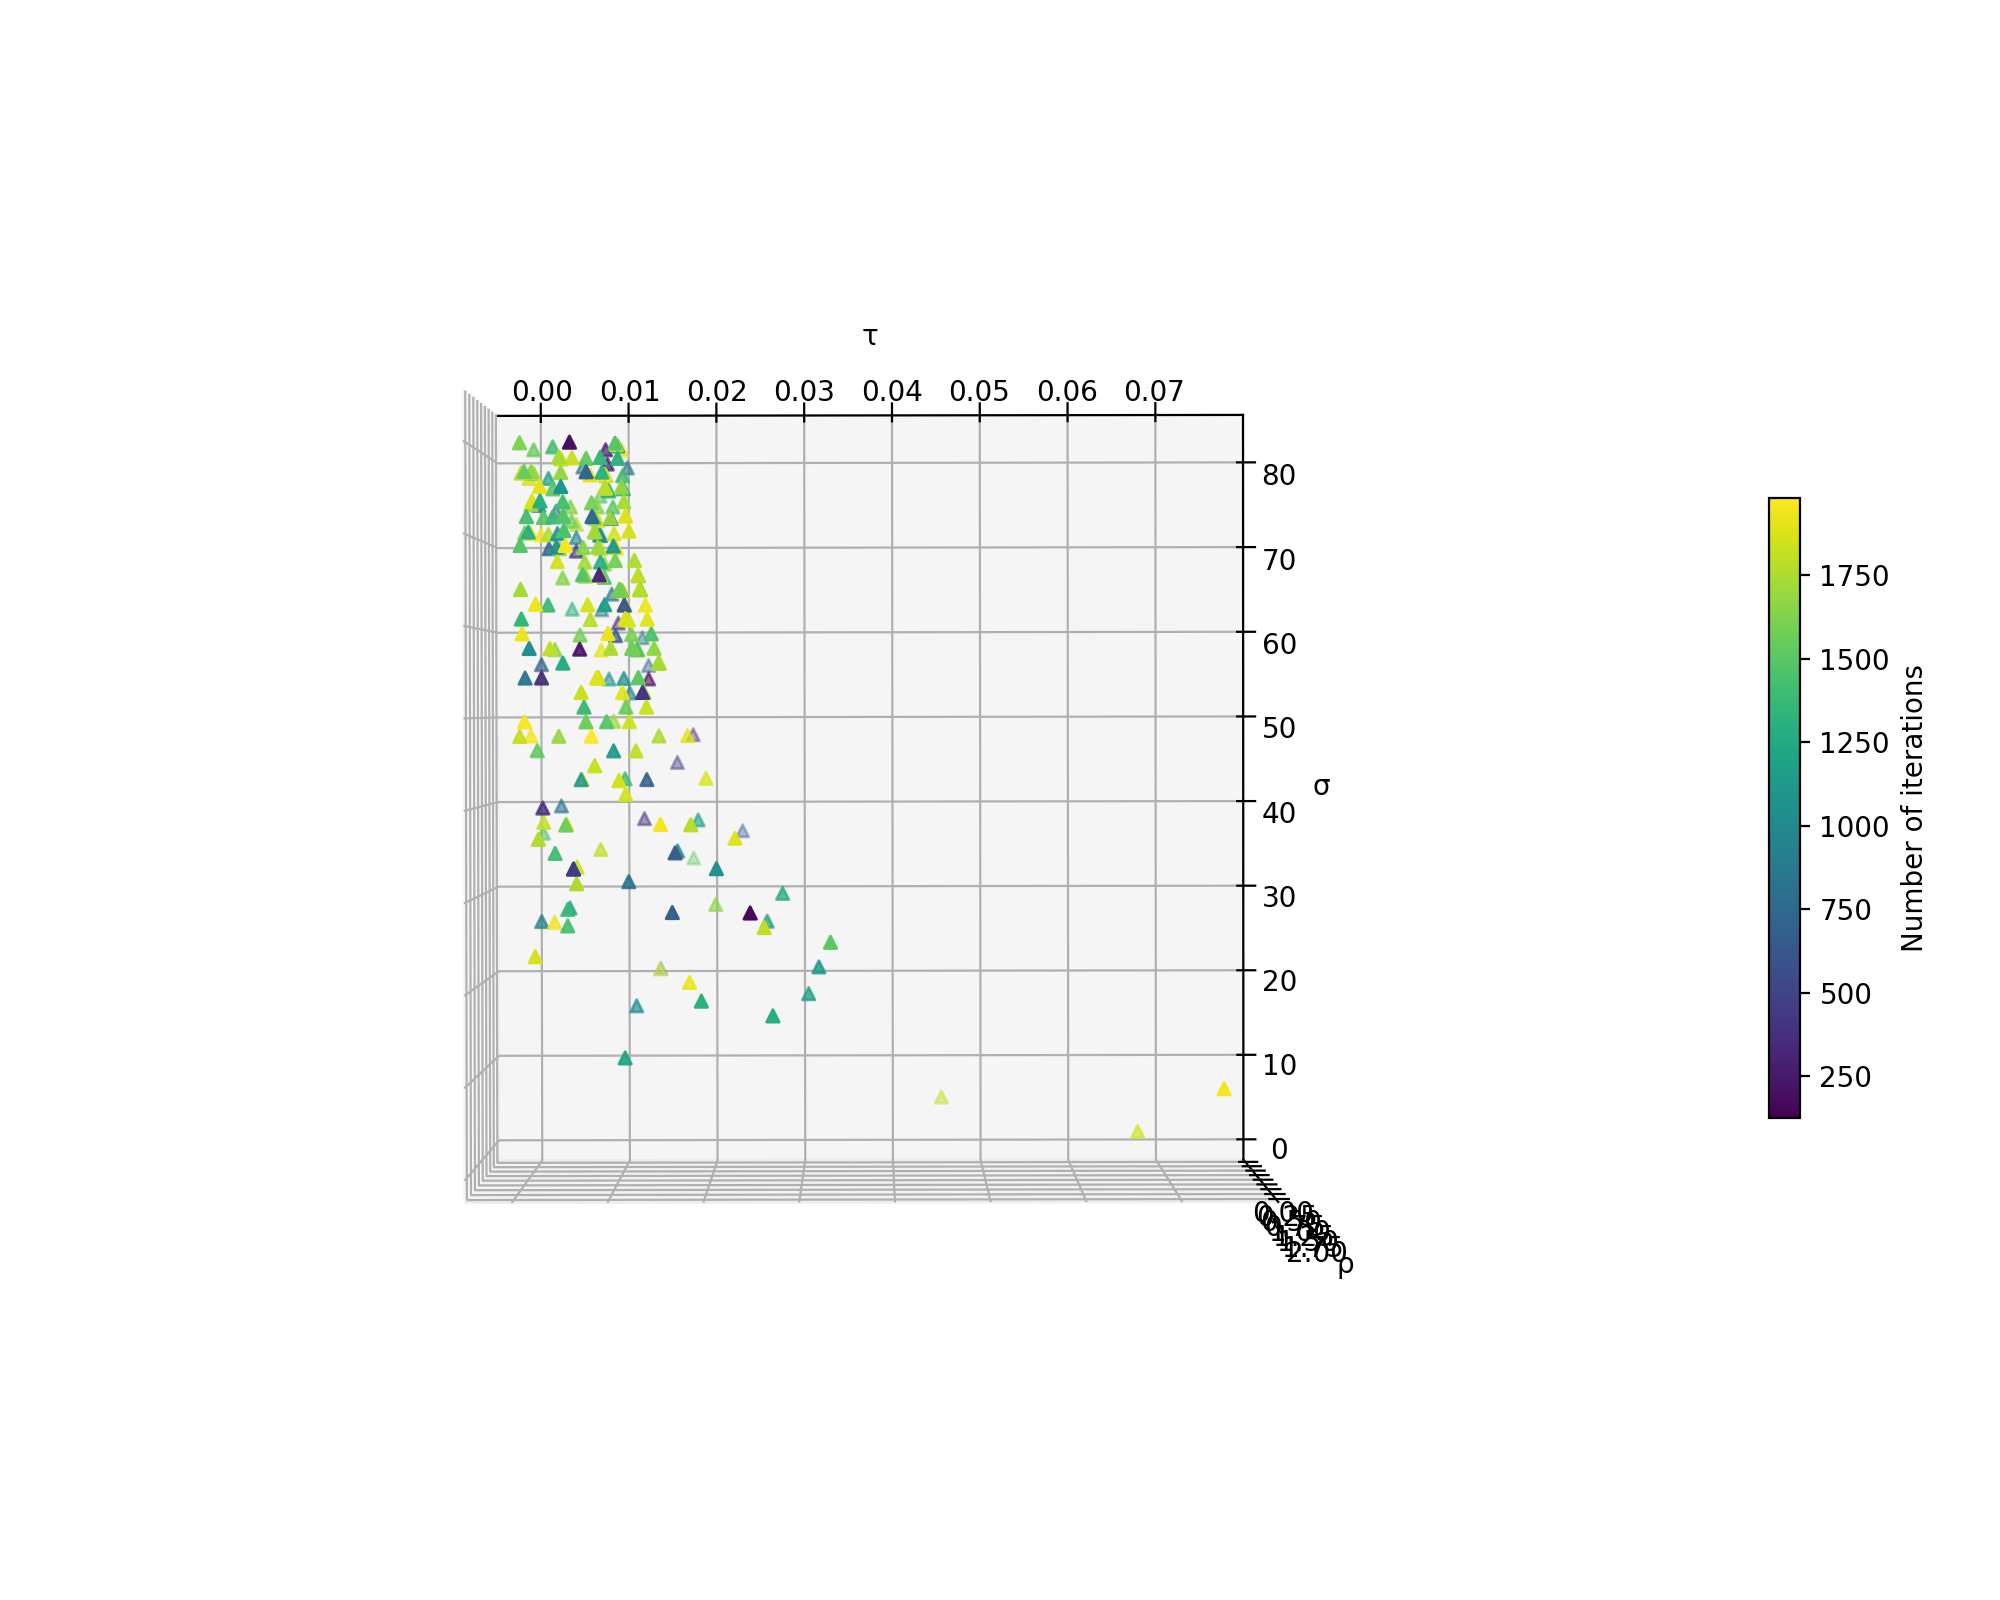

In [151]:
# Plot each parameter and resulting distance (coloured)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(df_1999['τ'], df_1999['σ'], df_1999['ρ'], marker='^', c=df_1999['its'])

ax.set_xlabel('τ')
ax.set_ylabel('σ')
ax.set_zlabel('ρ')
plt.colorbar(sc,fraction=0.02, pad=0.2,label='Number of iterations')

plt.show()

<IPython.core.display.Javascript object>


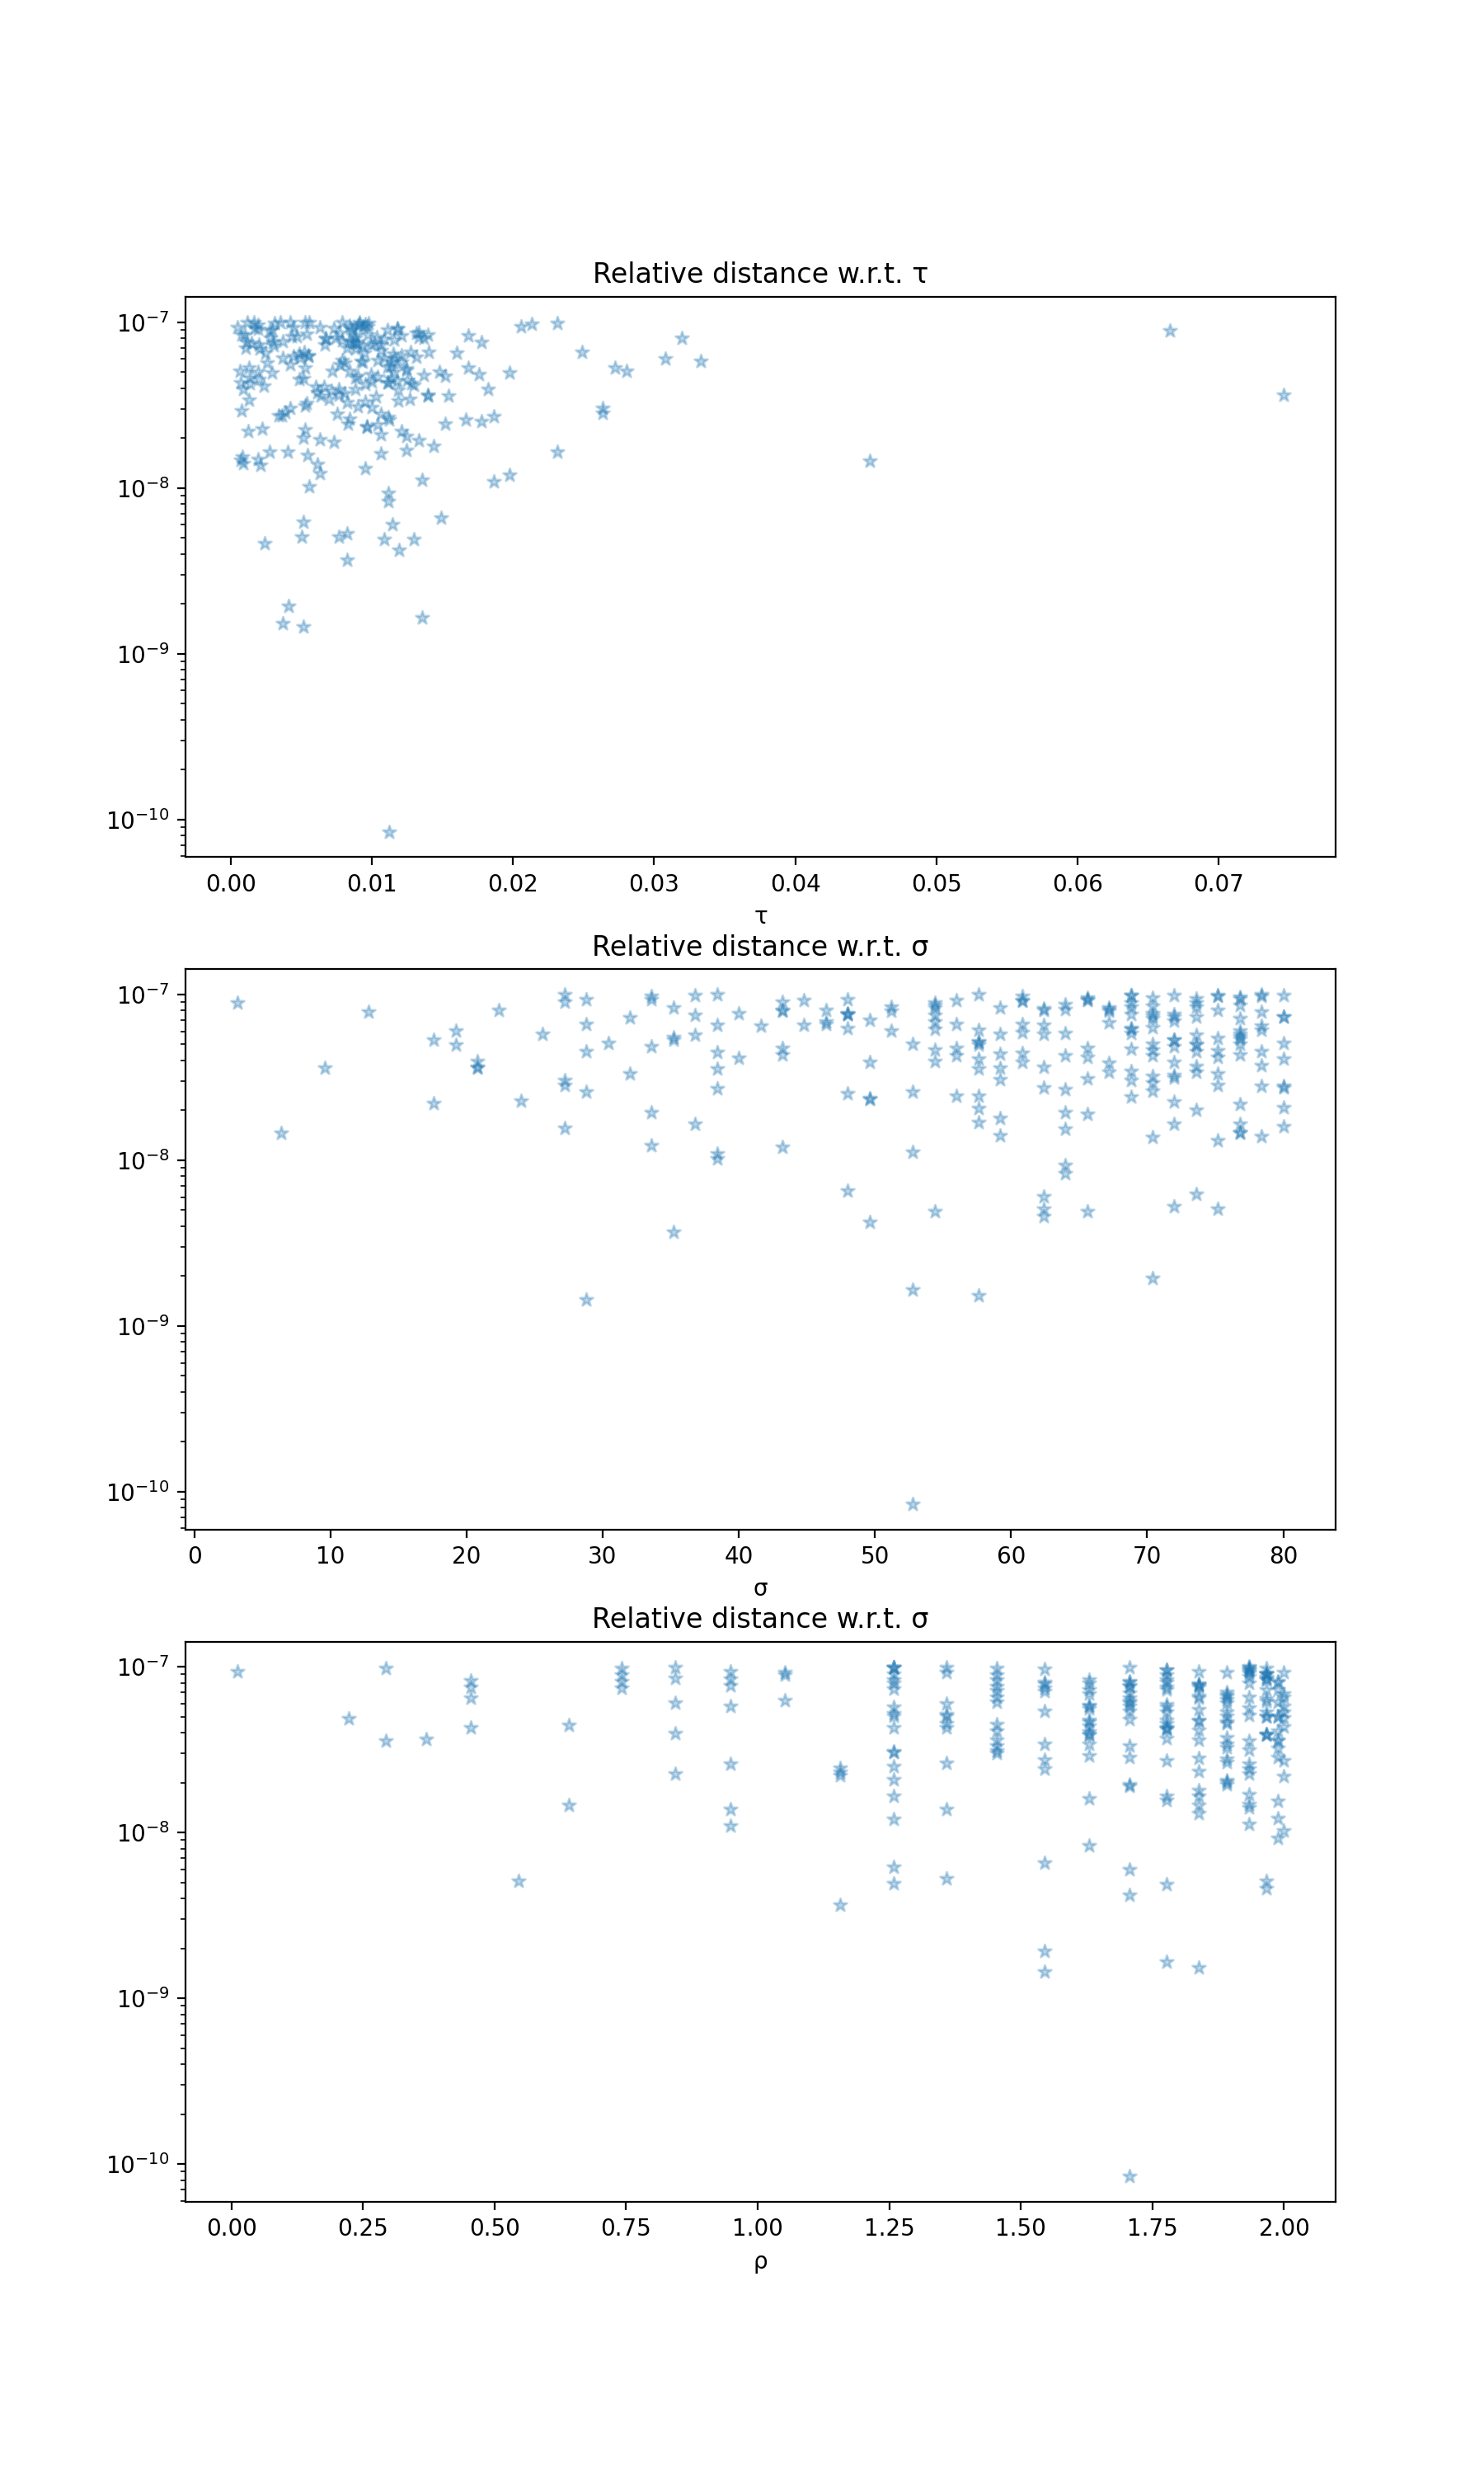

In [84]:
# Visualise faces
plt.figure(figsize = (9,15))

plt.subplot(3, 1, 1)
plt.title(r'Relative distance w.r.t. τ')
plt.scatter(df_1999['τ'],df_1999['dist_obj'], marker='*', alpha=0.3)
plt.xlabel('τ');plt.yscale('log')

plt.subplot(3, 1, 2)
plt.title(r'Relative distance w.r.t. σ')
plt.scatter(df_1999['σ'],df_1999['dist_obj'], marker='*', alpha=0.3)
plt.xlabel('σ');plt.yscale('log')

plt.subplot(3, 1, 3)
plt.title(r'Relative distance w.r.t. σ')
plt.scatter(df_1999['ρ'],df_1999['dist_obj'], marker='*', alpha=0.3)
plt.xlabel('ρ');plt.yscale('log')

plt.show()

We could check if there is any relationship between the values of $\rho$ and $\sigma$ for the smallest attained differences:

In [149]:
A = df_1999[df_1999['τ'] <= 0.012]
A[A['τ'] >= 0.009]

,τ,σ,ρ,its,dist_obj,time
3143,0.010330,46.4,1.777146,1138,8.066818e-08,0.061975
3317,0.010877,54.4,1.258819,1058,4.901622e-09,0.057492
4618,0.010273,57.6,1.987688,1748,3.573128e-08,0.094644
5422,0.011834,32.0,1.707107,821,3.337991e-08,0.045243
9561,0.009944,72.0,1.629320,723,7.312928e-08,0.039333
9562,0.009944,72.0,1.707107,1707,4.831653e-08,0.092662
9650,0.010170,70.4,1.544639,1860,7.453373e-08,0.101007
11155,0.011577,73.6,1.891007,1728,5.033572e-08,0.094441
12237,0.011834,72.0,1.965926,1886,3.888868e-08,0.102103
12556,0.009663,49.6,1.156434,1717,2.320572e-08,0.093439


In [133]:
df_18 = df_1999[df_1999['dist_obj'] <= 3e-8]
df_18.describe()

,τ,σ,ρ,its,dist_obj,time
count,66.000000,66.000000,66.000000,66.000000,6.600000e+01,66.000000
mean,0.009581,57.527273,1.615254,1565.439394,1.590553e-08,0.085041
std,0.007176,17.698036,0.366142,356.286709,8.633648e-09,0.019287
min,0.000693,6.400000,0.546010,407.000000,8.428000e-11,0.022250
25%,0.005061,48.400000,1.358368,1398.750000,8.553259e-09,0.076061
50%,0.008963,62.400000,1.742126,1703.000000,1.630211e-08,0.092372
75%,0.012348,72.000000,1.891007,1836.750000,2.343484e-08,0.099428
max,0.045303,80.000000,1.998630,1974.000000,2.918402e-08,0.107349


In [134]:
df_18[df_18.duplicated(subset=['τ','σ'])]

,τ,σ,ρ,its,dist_obj,time
12564,0.009663,49.6,1.838671,1492,2.351121e-08,0.081031
17276,0.012430,57.6,1.933580,1574,1.696182e-08,0.085631
17421,0.010651,80.0,1.629320,1162,1.604922e-08,0.063042
17425,0.010651,80.0,1.891007,1477,2.793833e-08,0.080336
17609,0.018645,38.4,1.998630,1774,2.705845e-08,0.096419
19585,0.005145,73.6,1.891007,1426,2.009347e-08,0.077509
21175,0.011187,64.0,1.891007,1812,2.662266e-08,0.098734
21178,0.011187,64.0,1.987688,1577,9.281737e-09,0.085698
26636,0.013560,52.8,1.933580,407,1.122847e-08,0.022250
30658,0.006340,33.6,1.987688,1233,1.223730e-08,0.066834


<IPython.core.display.Javascript object>


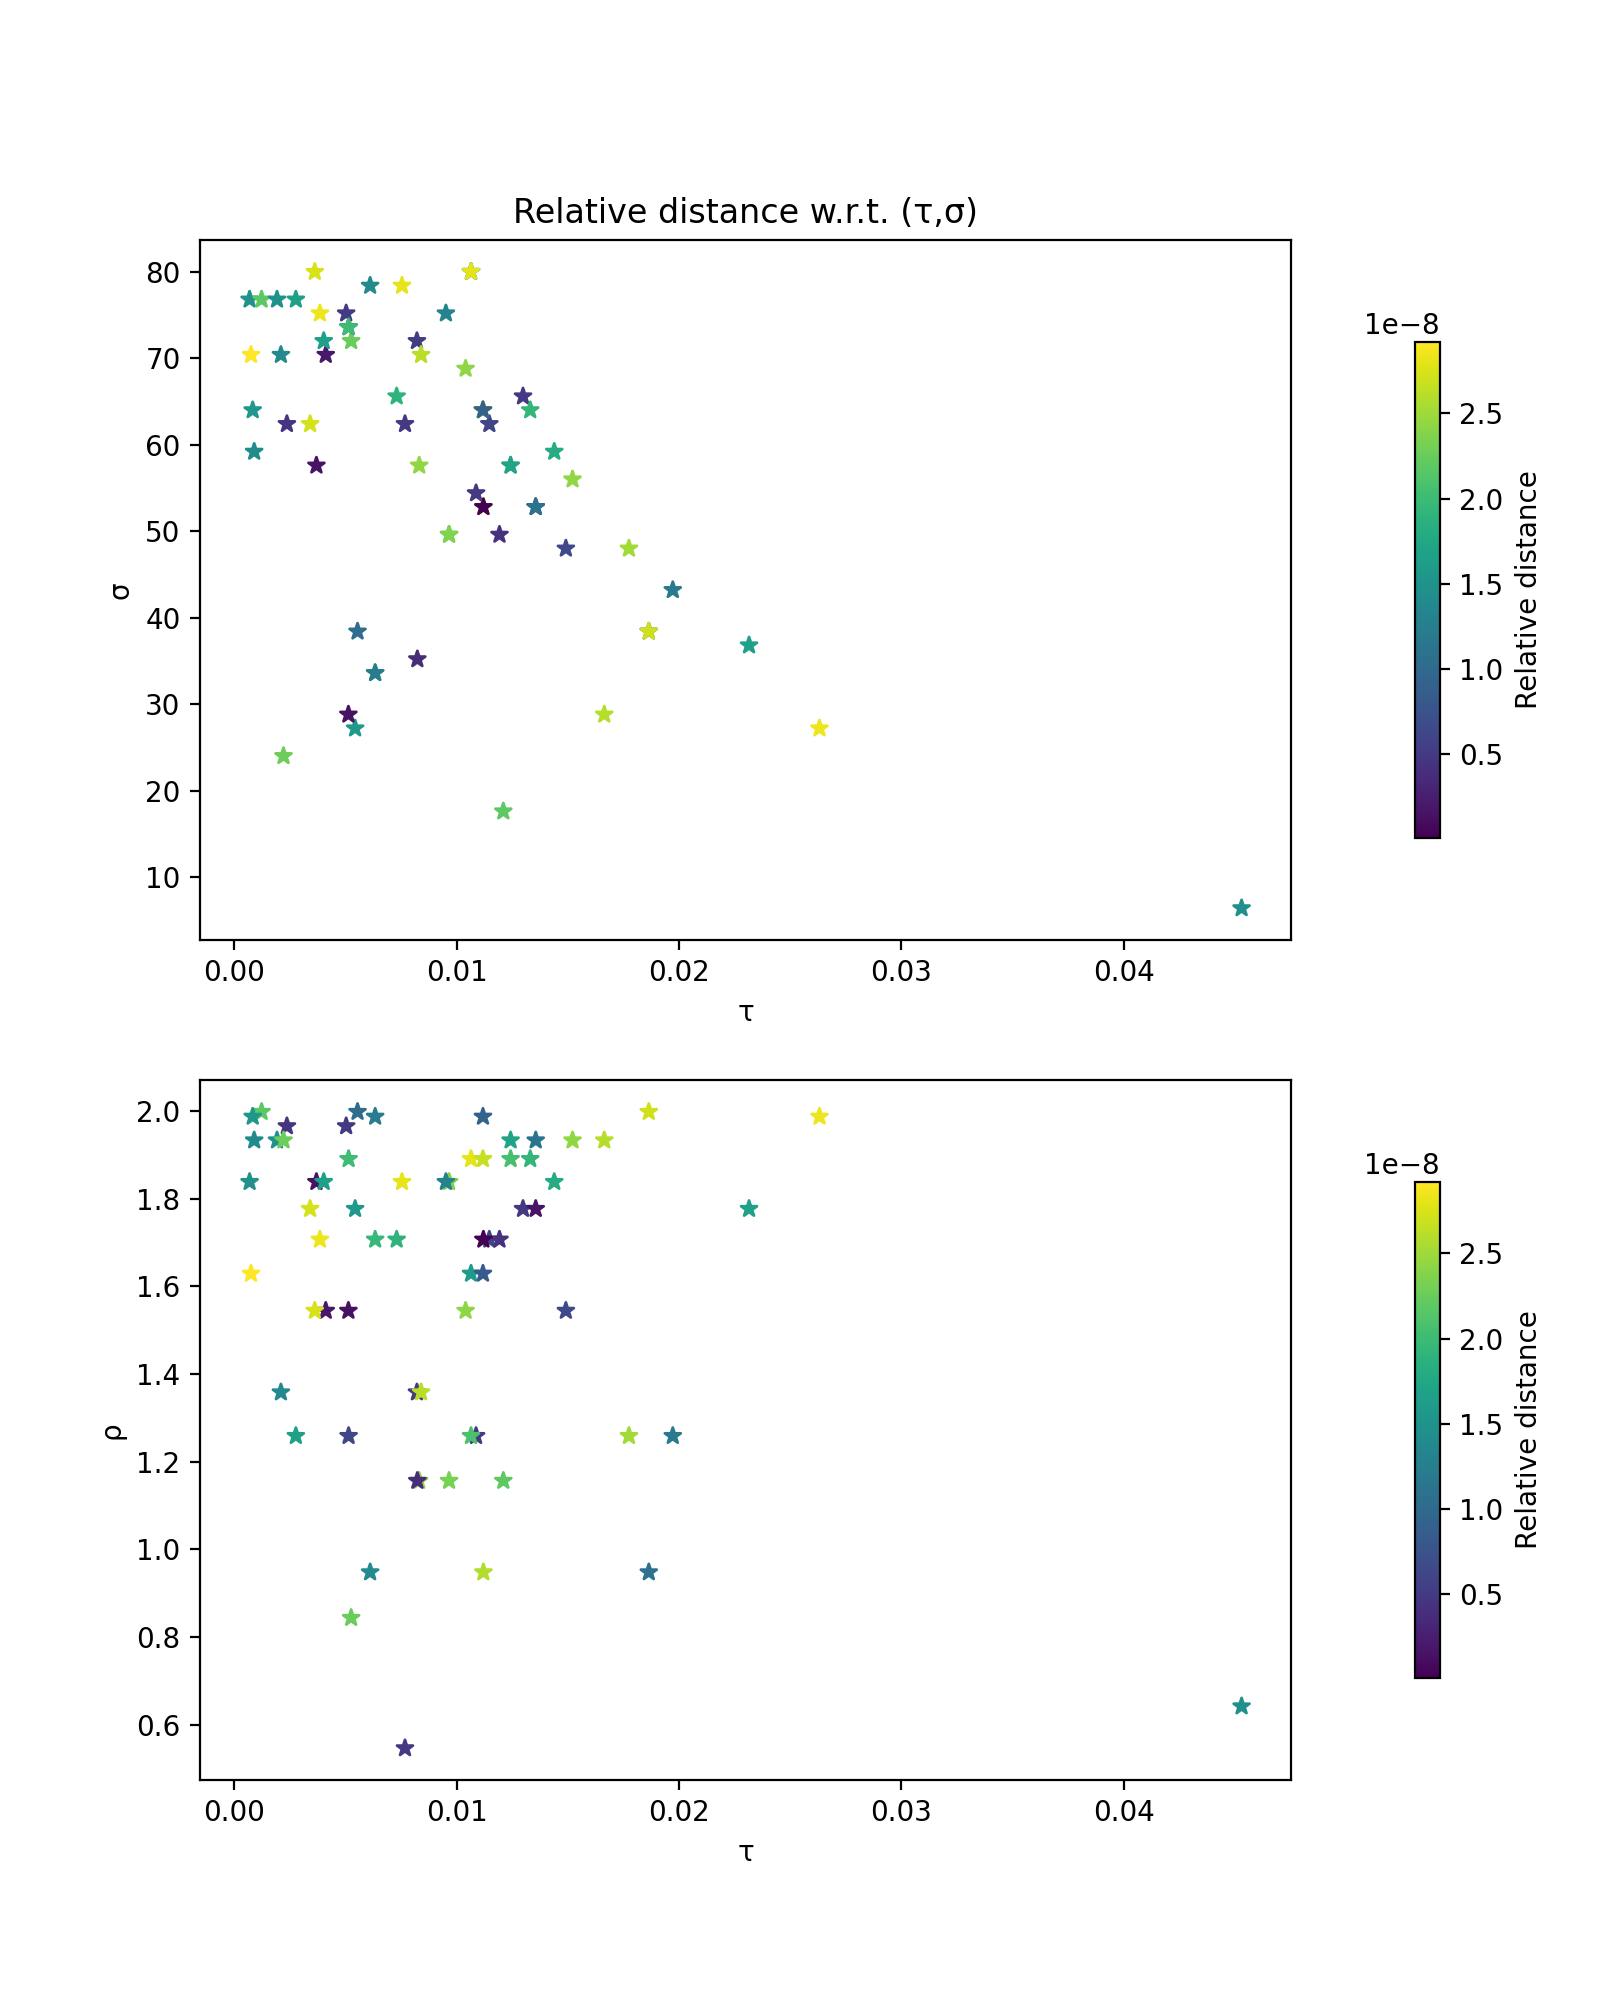

In [135]:
plt.figure(figsize = (8,10))

plt.subplot(2, 1, 1)
plt.title(r'Relative distance w.r.t. (τ,σ)')
sc = plt.scatter(df_18['τ'],df_18['σ'], marker='*', c=df_18['dist_obj'])
plt.colorbar(sc,fraction=0.02, pad=0.1,label='Relative distance')
plt.xlabel('τ');    plt.ylabel('σ');

plt.subplot(2, 1, 2)
sc = plt.scatter(df_18['τ'],df_18['ρ'], marker='*', c=df_18['dist_obj'])
plt.colorbar(sc,fraction=0.02, pad=0.1,label='Relative distance')
plt.xlabel('τ');    plt.ylabel('ρ');

plt.show()

---

In [141]:
df_400 = df_1999[df_1999['its'] <= 500]
df_400

,τ,σ,ρ,its,dist_obj,time
6553,0.013161,54.4,0.843566,124,8.586706e-08,0.006884
6669,0.015982,44.8,0.455361,486,6.525340e-08,0.026357
11631,0.006575,57.6,1.629320,182,4.080054e-08,0.010002
13755,0.005504,68.8,1.052336,425,6.284739e-08,0.023293
13931,0.012482,38.4,0.641632,427,4.465117e-08,0.023480
17327,0.009132,78.4,1.258819,307,9.966352e-08,0.016786
17859,0.017751,48.0,0.455361,424,7.573249e-08,0.023131
19253,0.002719,54.4,1.777146,383,8.908383e-08,0.020823
23368,0.005991,80.0,1.987688,202,4.086385e-08,0.011023
23532,0.009732,60.8,0.741181,359,9.799001e-08,0.019537


<IPython.core.display.Javascript object>


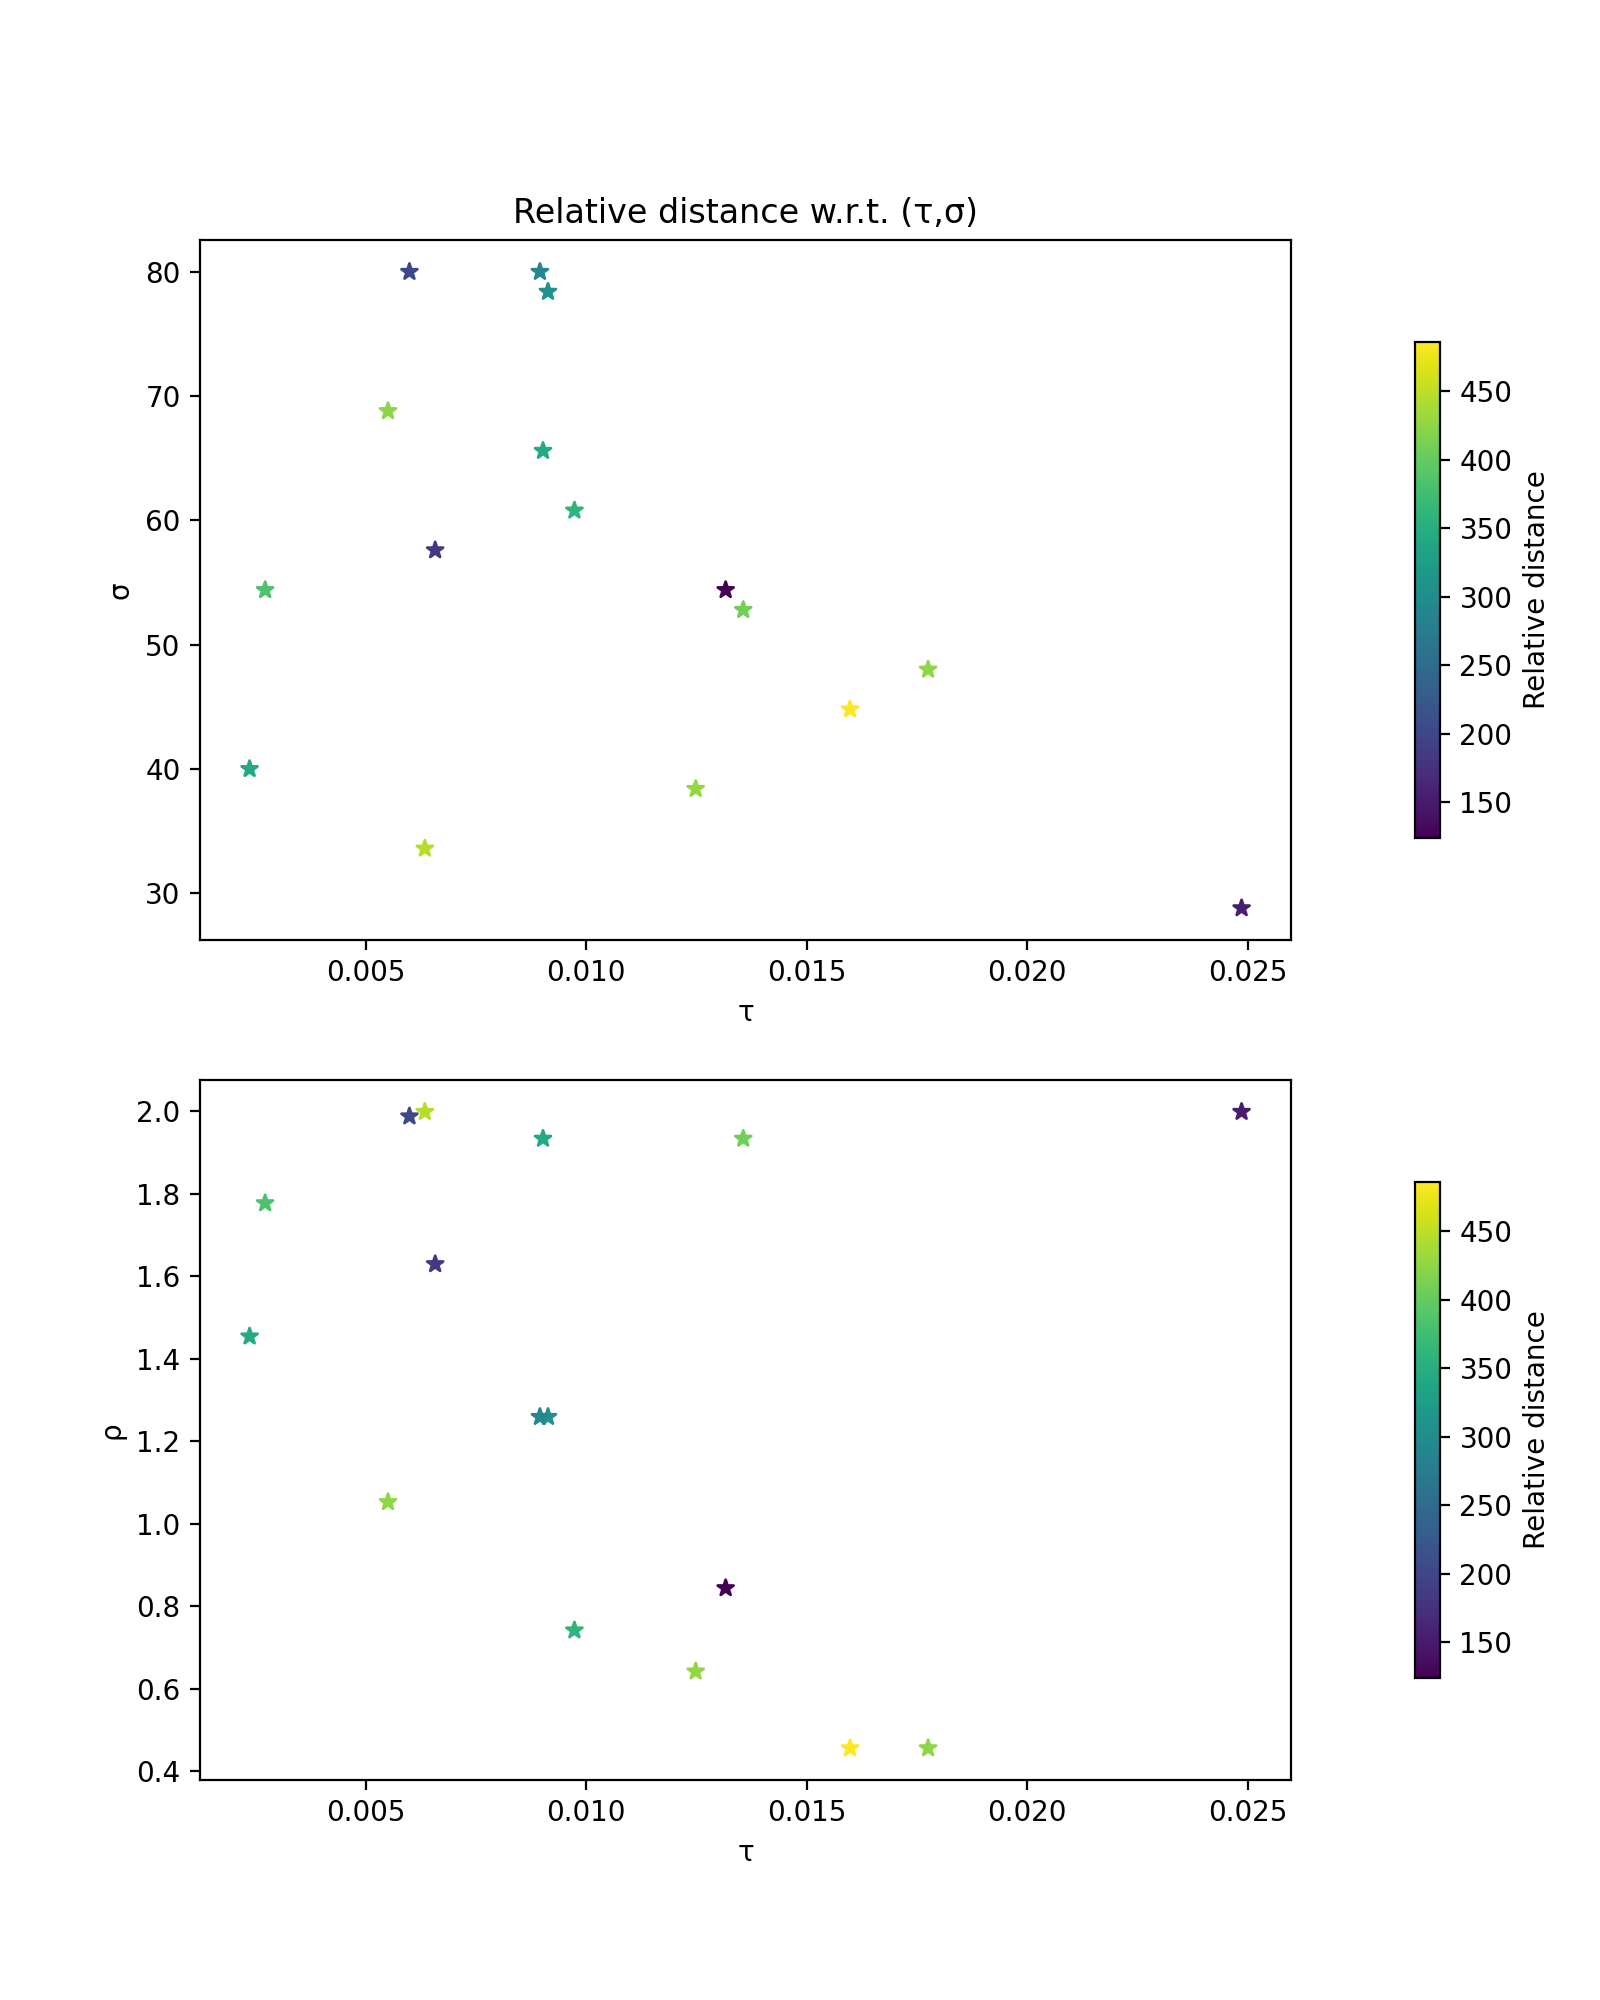

In [142]:
plt.figure(figsize = (8,10))

plt.subplot(2, 1, 1)
plt.title(r'Relative distance w.r.t. (τ,σ)')
sc = plt.scatter(df_400['τ'],df_400['σ'], marker='*', c=df_400['its'])
plt.colorbar(sc,fraction=0.02, pad=0.1,label='Relative distance')
plt.xlabel('τ');    plt.ylabel('σ');

plt.subplot(2, 1, 2)
sc = plt.scatter(df_400['τ'],df_400['ρ'], marker='*', c=df_400['its'])
plt.colorbar(sc,fraction=0.02, pad=0.1,label='Relative distance')
plt.xlabel('τ');    plt.ylabel('ρ');

plt.show()